*Downloading and cleaning data on flights and airports*

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import urllib.request as req

# Download data on flights and airports

### Flights, 2007

Data comes from the US Bureau of Transportation Statistics (BTS) but is gathered with complete data up to 2007 at

http://stat-computing.org/dataexpo/2009/the-data.html

In [2]:
# Flights
filename = '2007.csv.bz2'
url = 'http://stat-computing.org/dataexpo/2009/'+str(filename)
req.urlretrieve(url,filename)
Flights = pd.read_csv(filename)

# Pickle un-cleaned: too big for Github, as >100 MB
Flights.to_pickle("Flights.pkl")

print('Rows:', len(Flights.index))

Rows: 7453215


In [3]:
Flights.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2007,1,1,1,1232.0,1225,1341.0,1340,WN,2891,...,4,11,0,NaN,0,0,0,0,0,0
1,2007,1,1,1,1918.0,1905,2043.0,2035,WN,462,...,5,6,0,NaN,0,0,0,0,0,0
2,2007,1,1,1,2206.0,2130,2334.0,2300,WN,1229,...,6,9,0,NaN,0,3,0,0,0,31
3,2007,1,1,1,1230.0,1200,1356.0,1330,WN,1355,...,3,8,0,NaN,0,23,0,0,0,3
4,2007,1,1,1,831.0,830,957.0,1000,WN,2278,...,3,9,0,NaN,0,0,0,0,0,0


***Unique journeys for price scraping***

In [4]:
# Choose columns for later
scrape_data = Flights[["Year","Month","DayofMonth","DayOfWeek","DepTime","UniqueCarrier","Origin","Dest","Distance"]]

# Prepare data for scraping
scrape_data["Journey"] = scrape_data["Origin"]+Flights["Dest"]
scrape_data = scrape_data.drop_duplicates(subset = "Journey", keep = "first").reset_index(drop=True)

# Pickle it for price scraping
scrape_data.to_pickle("scrape_data.pkl")

scrape_data.tail(2)

C:\Users\morte\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Year,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Journey
5340,2007,12,3,1,1045.0,9E,PIR,JAX,1395,PIRJAX
5341,2007,12,9,7,1519.0,AS,ANC,HNL,2777,ANCHNL


### Flights, 2018

The newest data from BTS must be downloaded manually from https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236

First tick the following "Field Names":

* "Year"
* "Month"
* "DayofMonth"
* "DayOfWeek"
* "Reporting_Airline" (UniqueCarrier)
* "Origin"
* "Dest"
* "DepTime"
* "Distance"

For each month of 2018:

1. Press download
2. Locate (or create) the folder "Data" within the cd of this .ipynb-file
3. Name the download after the number of the month, i.e. from 1-12
4. Save it in the folder

In [33]:
data = []
for m in range(1,13):
    df = pd.read_csv("Data/Morten/"+str(m)+".zip")
    data.append(df)
Flights18 = pd.concat(data, axis=0).drop('Unnamed: 10', axis=1).reset_index(drop=True)
Flights18.columns = ["Year","Month","DayofMonth","DayOfWeek","Date","UniqueCarrier","Origin","Dest","ActualElapsedTime","Distance"]
Flights18 = Flights18[["Year","Month","DayofMonth","DayOfWeek","Date","UniqueCarrier","Origin","Dest","ActualElapsedTime","Distance"]]

Flights18.tail(2)



,Year,Month,DayofMonth,DayOfWeek,Date,UniqueCarrier,Origin,Dest,ActualElapsedTime,Distance
7213444,2018,12,27,4,2018-12-27,AA,BNA,CLT,76.0,328.0
7213445,2018,12,28,5,2018-12-28,AA,BNA,CLT,NaN,328.0


In [36]:
Flights18.to_pickle("Flights18.pkl")

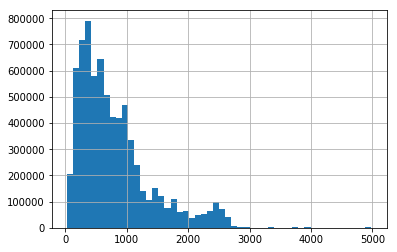

In [43]:
Flights18["Distance"].hist(bins = 50)

In [35]:
Flights18.isna().sum()

Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
Date                      0
UniqueCarrier             0
Origin                    0
Dest                      0
ActualElapsedTime    134442
Distance                  0
dtype: int64

### Airports

Data comes from https://openflights.org/data.html

In [6]:
# Load data
airports_raw = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat', header = None) #load data

# Assign column names
airports_raw.columns = ["Airport_id","Name","City","Country","3DigitId","4DigitId","Lat","Lon","Altitude_ft","Timezone","DST","TZ","Type","Source"] 

# Pick relevant columns for analysis
airports_df = airports_raw[["Airport_id","Name","City","Country","3DigitId","Lat","Lon","Altitude_ft"]]

# Limit to US Airports
airports_US = airports_df[airports_df['Country']=='United States'].reset_index(drop=True)

# Pickle the dataframe for future use
airports_US.to_pickle("Airports.pkl")

print('Rows, all:', len(airports_df.index))
print('Rows, US: ', len(airports_US.index))
print('- of which missing 3DigitId:', airports_US['3DigitId'].value_counts(dropna=False).nlargest(1)[0])
print('- of which containing 3DigitId:', airports_US['3DigitId'].nunique())
airports_US.tail(2)

Rows, all: 7698
Rows, US:  1512
- of which missing 3DigitId: 261
- of which containing 3DigitId: 1252


,Airport_id,Name,City,Country,3DigitId,Lat,Lon,Altitude_ft
1510,13759,Oswego County Airport,Fulton,United States,\N,43.350800,-76.388100,475
1511,13803,Mitchell Municipal Airport,Mitchell,United States,MHE,43.774799,-98.038597,1304


In [7]:
airports = pd.read_pickle("Airports.pkl")

In [8]:
# Data on US airports from stat-computing.org
# filename = 'airports.csv'
# url = 'http://stat-computing.org/dataexpo/2009/'+str(filename)
# req.urlretrieve(url,filename)
# Airports = pd.read_csv(filename)

# print('Shape:', Airports.shape)
# Airports.head(2)

# Data cleaning for flights data, 2007

### Count number of flights between airports

In [9]:
# Select variables from which to create network. Must contain two columns of nodes, since 
# nx.from_pandas_edgelist() views each row as an edge. Can also contains attributes, e.g. Distance. 
FlightsNx = Flights[["Origin","Dest","Distance"]]

# Take counts (i.e. how many origin to destination flights in the dataset)
counts = pd.DataFrame(Flights.groupby(["Origin","Dest"])["Year"].count())
counts.columns = ["count"]
FlightsNx = FlightsNx.merge(counts, how = 'left', on = ["Origin","Dest"])

# Drop duplicates 
FlightsNx = FlightsNx.drop_duplicates()

# Count number of take-offs from origin: 
orig_takeoff = pd.DataFrame(FlightsNx.groupby(["Origin"])["count"].sum())
orig_takeoff.columns = ["origin_takeoff"]
# Merge to network dataset: 
FlightsNx = FlightsNx.merge(orig_takeoff, how = "left", on = "Origin")

# Count number of take-offs from dest
dest_takeoff = pd.DataFrame(FlightsNx.groupby(["Origin"])["count"].sum())
dest_takeoff.columns = ["dest_takeoff"]
FlightsNx = FlightsNx.merge(dest_takeoff, how = "left", left_on = "Dest", right_on = "Origin")

# Count number of landings at destination
dest_lands = pd.DataFrame(FlightsNx.groupby(["Dest"])["count"].sum())
dest_lands.columns = ["dest_landing"]
FlightsNx = FlightsNx.merge(dest_lands, how = "left", on = "Dest")

orig_lands = pd.DataFrame(FlightsNx.groupby(["Dest"])["count"].sum())
orig_lands.columns = ["orig_landing"]
FlightsNx = FlightsNx.merge(orig_lands, how = "left", left_on = "Origin", right_on = "Dest")

# Construct totals (flights)
FlightsNx["Origin_flights"] = FlightsNx["origin_takeoff"]+FlightsNx["orig_landing"]
FlightsNx["Destination_flights"] = FlightsNx["dest_takeoff"]+FlightsNx["dest_landing"]

# Drop auxiliary vars
FlightsNx.drop(["origin_takeoff","dest_takeoff","dest_landing","orig_landing"], axis = 1, inplace = True)

print('Rows:', len(FlightsNx.index))
FlightsNx.head(2)

Rows: 5342


,Origin,Dest,Distance,count,Origin_flights,Destination_flights
0,SMF,ONT,389,4093,116158,83287.0
1,SMF,PDX,479,2721,116158,117237.0


### Implement as network
For function documentation, see:  
https://networkx.github.io/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html?highlight=from_pandas_edgelist#networkx.convert_matrix.from_pandas_edgelist

In [10]:
Network = nx.from_pandas_edgelist(FlightsNx, source = "Origin", target = "Dest", edge_attr = True)

### Degree distribution

In [11]:
# docs: https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality 
# Find degree: 
degree_dict = nx.algorithms.centrality.degree_centrality(Network) 
degree_values = list(degree_dict.values())
# Create dataframe
degrees = pd.DataFrame(degree_values)
degrees.columns = ["degree"]
degrees["degree_unnormalized"] = degrees["degree"]*(len(Network.nodes)-1)
degrees["airport"] = degree_dict.keys()

# Pickle for descriptive
degrees.to_pickle("Degrees.pkl")

In [12]:
# Add degree to FlightsNx data
FlightsNx = FlightsNx.merge(degrees, how = "left", left_on = "Origin", right_on = "airport")
FlightsNx = FlightsNx.drop("airport", axis = 1)
FlightsNx = FlightsNx.rename(columns = {"degree": "origin_degree", "degree_unnormalized": "origin_degree_unn"})

FlightsNx = FlightsNx.merge(degrees, how = "left", left_on = "Dest", right_on = "airport")
FlightsNx = FlightsNx.drop("airport", axis = 1).reset_index(drop=True)
FlightsNx = FlightsNx.rename(columns = {"degree": "dest_degree", "degree_unnormalized": "dest_degree_unn"})

FlightsNx.tail(2)

,Origin,Dest,Distance,count,Origin_flights,Destination_flights,origin_degree,origin_degree_unn,dest_degree,dest_degree_unn
5340,PIR,JAX,1395,2,8,71860.0,0.006472,2.0,0.126214,39.0
5341,ANC,HNL,2777,23,39504,135193.0,0.097087,30.0,0.080906,25.0


In [13]:
# Save cleaned to pickle
FlightsNx.to_pickle("FlightsNx.pkl") # only 0.4 MB

# Data cleaning for flights data, 2018 (same code)

In [14]:
### Count number of flights between airports

# Select variables from which to create network. Must contain two columns of nodes, since 
# nx.from_pandas_edgelist() views each row as an edge. Can also contains attributes, e.g. Distance. 
FlightsNx = Flights18[["Origin","Dest","Distance"]]

# Take counts (i.e. how many origin to destination flights in the dataset)
counts = pd.DataFrame(Flights.groupby(["Origin","Dest"])["Year"].count())
counts.columns = ["count"]
FlightsNx = FlightsNx.merge(counts, how = 'left', on = ["Origin","Dest"])

# Drop duplicates 
FlightsNx = FlightsNx.drop_duplicates()

# Count number of take-offs from origin: 
orig_takeoff = pd.DataFrame(FlightsNx.groupby(["Origin"])["count"].sum())
orig_takeoff.columns = ["origin_takeoff"]
# Merge to network dataset: 
FlightsNx = FlightsNx.merge(orig_takeoff, how = "left", on = "Origin")

# Count number of take-offs from dest
dest_takeoff = pd.DataFrame(FlightsNx.groupby(["Origin"])["count"].sum())
dest_takeoff.columns = ["dest_takeoff"]
FlightsNx = FlightsNx.merge(dest_takeoff, how = "left", left_on = "Dest", right_on = "Origin")

# Count number of landings at destination
dest_lands = pd.DataFrame(FlightsNx.groupby(["Dest"])["count"].sum())
dest_lands.columns = ["dest_landing"]
FlightsNx = FlightsNx.merge(dest_lands, how = "left", on = "Dest")

orig_lands = pd.DataFrame(FlightsNx.groupby(["Dest"])["count"].sum())
orig_lands.columns = ["orig_landing"]
FlightsNx = FlightsNx.merge(orig_lands, how = "left", left_on = "Origin", right_on = "Dest")

# Construct totals (flights)
FlightsNx["Origin_flights"] = FlightsNx["origin_takeoff"]+FlightsNx["orig_landing"]
FlightsNx["Destination_flights"] = FlightsNx["dest_takeoff"]+FlightsNx["dest_landing"]

# Drop auxiliary vars
FlightsNx.drop(["origin_takeoff","dest_takeoff","dest_landing","orig_landing"], axis = 1, inplace = True)


### Implement as network

Network = nx.from_pandas_edgelist(FlightsNx, source = "Origin", target = "Dest", edge_attr = True)


### Degree distribution

# docs: https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality 
# Find degree: 
degree_dict = nx.algorithms.centrality.degree_centrality(Network) 
degree_values = list(degree_dict.values())
# Create dataframe
degrees = pd.DataFrame(degree_values)
degrees.columns = ["degree"]
degrees["degree_unnormalized"] = degrees["degree"]*(len(Network.nodes)-1)
degrees["airport"] = degree_dict.keys()

# Pickle for descriptive
degrees.to_pickle("Degrees18.pkl")


# Add degree to FlightsNx data
FlightsNx = FlightsNx.merge(degrees, how = "left", left_on = "Origin", right_on = "airport")
FlightsNx = FlightsNx.drop("airport", axis = 1)
FlightsNx = FlightsNx.rename(columns = {"degree": "origin_degree", "degree_unnormalized": "origin_degree_unn"})

FlightsNx = FlightsNx.merge(degrees, how = "left", left_on = "Dest", right_on = "airport")
FlightsNx = FlightsNx.drop("airport", axis = 1).reset_index(drop=True)
FlightsNx = FlightsNx.rename(columns = {"degree": "dest_degree", "degree_unnormalized": "dest_degree_unn"})


# Save cleaned to pickle
FlightsNx.to_pickle("FlightsNx18.pkl")

FlightsNx.tail(2)

,Origin,Dest,Distance,count,Origin_flights,Destination_flights,origin_degree,origin_degree_unn,dest_degree,dest_degree_unn
6336,PHL,ABE,55.0,NaN,207165.0,10582.0,0.233146,83.0,0.030899,11.0
6337,HSV,IAD,596.0,534.0,15803.0,163852.0,0.030899,11.0,0.202247,72.0
